# Mutation Selection

This page is an example of our hypothesis testing of enzyme activity impact factors using API falsifypack, and the process for Bayesian optimization of the selection of mutants from random mutation library using the results of previous verification

### Hypothesis Testing

In [103]:
import pandas as pd 
import expAscribe as ea
priori = pd.read_csv('./data/Wetlab/partial_links.csv',header=None)
ea.array_to_gml(priori.to_numpy(),'./data/Wetlab/influence_path.gml',["binding energy","pocket volume","bottleneck radius","length", "enzymatic activity"])

Test permutations of given graph: 100%|██████████| 100/100 [00:35<00:00,  2.81it/s]


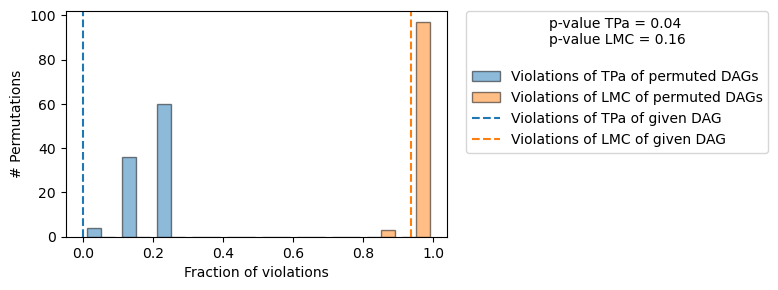

In [104]:
ana = ea.falsifypack('./data/Wetlab/augmented_data.csv',"./data/Wetlab/influence_path.gml",significance_level_=0.2,n_perm=100)

In [3]:
print(ana)

+-------------------------------------------------------------------------------------------------------+
|                                         Falsificaton Summary                                          |
+-------------------------------------------------------------------------------------------------------+
| The given DAG is informative because 4 / 100 of the permutations lie in the Markov                    |
| equivalence class of the given DAG (p-value: 0.04).                                                   |
| The given DAG violates 15/16 LMCs and is better than 84.0% of the permuted DAGs (p-value: 0.16).      |
| Based on the provided significance level (0.2) and because the DAG is informative,                    |
| we do not reject the DAG.                                                                             |
+-------------------------------------------------------------------------------------------------------+


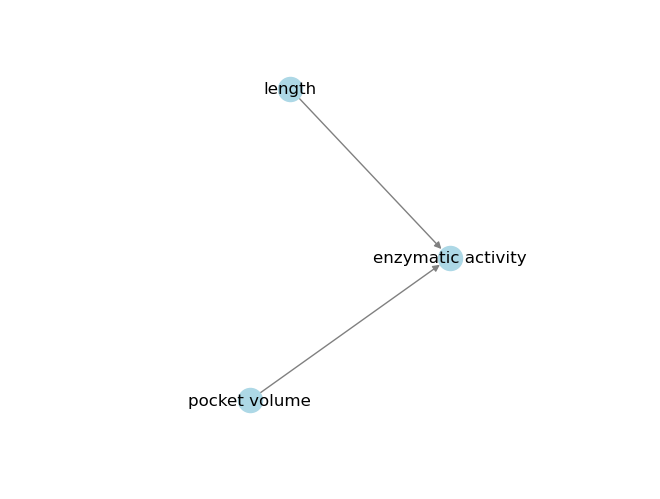

In [93]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.read_gml("./data/Wetlab/influence_path.gml")
isolated_nodes = [node for node, degree in dict(G.degree()).items() if degree == 0]
G.remove_nodes_from(isolated_nodes)
pos = nx.spring_layout(G, center=(0, 0))
nx.draw(G, pos, node_color='lightblue',  edge_color='gray')
nx.draw_networkx_labels(G, pos)
plt.xlim(-1.5, 1.5)  
plt.ylim(-1.5, 1.5)  
plt.show()


### Bayesian optimization

In [10]:
data= pd.read_csv('./data/Wetlab/original_data.csv')
data = data.dropna()
data = data.select_dtypes(include=['number'])
data

,binding energy,pocket volume,bottleneck radius,length,enzymatic activity
1,-7.25,1441.0,2.0,5.7,85.65
2,-6.77,1179.0,2.0,5.4,66.70
3,-6.74,1122.0,2.1,3.5,132.46
4,-6.44,659.0,2.5,2.4,85.13
5,-5.02,1267.0,2.2,3.4,93.89
6,-6.34,1502.0,2.0,5.3,57.75
7,-6.16,1262.0,2.1,4.9,49.01
8,-6.34,1487.0,2.0,4.9,54.78
9,-5.95,729.0,2.1,5.3,12.26
10,-6.21,1229.0,2.0,4.9,40.33


In [18]:
data_new = data[['pocket volume', 'length', ' enzymatic activity']].rename(columns={
    'pocket volume': 'x',
    'length': 'y',
    ' enzymatic activity': 'z'
})
data_new

,x,y,z
1,1441.0,5.7,85.65
2,1179.0,5.4,66.70
3,1122.0,3.5,132.46
4,659.0,2.4,85.13
5,1267.0,3.4,93.89
6,1502.0,5.3,57.75
7,1262.0,4.9,49.01
8,1487.0,4.9,54.78
9,729.0,5.3,12.26
10,1229.0,4.9,40.33


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization, UtilityFunction
from matplotlib import cm
from PIL import Image
import io
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

'''
data_new = pd.DataFrame({
    'x': np.random.uniform(-2, 10, 100),
    'y': np.random.uniform(-2, 10, 100),
    'z': np.sin(np.random.uniform(-2, 10, 100)) + np.cos(np.random.uniform(-2, 10, 100))
})
'''

X_train = data_new[['x', 'y']].values
y_train = data_new['z'].values


kernel = C(1.5, (1e-2, 1e2)) * RBF(0.5, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp.fit(X_train, y_train)

def target_function(x, y):
    X_test = np.array([[x, y]])
    return gp.predict(X_test)[0]

x = np.linspace(0, 2000, 100)
y = np.linspace(-10, 25, 100)
X, Y = np.meshgrid(x, y)
grid = np.c_[X.ravel(), Y.ravel()]  

Z = np.array([target_function(xi, yi) for xi, yi in grid])
Z = Z.reshape(X.shape)  

optimizer = BayesianOptimization(
    f=target_function,
    pbounds={'x': (0, 2000), 'y': (0, 20)},
    random_state=42,
    verbose=1
)
acq_function = UtilityFunction(kind="ei", kappa=5)

optimizer.register({'x': 1000, 'y': 6}, target_function(1000, 6))
optimizer.register({'x': 1200, 'y': 5}, target_function(1200, 5))

def posterior(optimizer, x_obs, y_obs, grid):
    optimizer._gp.fit(x_obs, y_obs)
    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma

def plot_gp(optimizer, X, Y, Z, step=0):
    fig, axs = plt.subplots(2, 2, figsize=(18, 14))
    grid = np.c_[X.ravel(), Y.ravel()]
    
    x_obs = np.array([[res["params"]["x"], res["params"]["y"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])
    
    mu, sigma = posterior(optimizer, x_obs, y_obs, grid)
    mu = mu.reshape(X.shape)
    sigma = sigma.reshape(X.shape)

    c1 = axs[0, 0].contourf(X, Y, Z, cmap='rainbow')
    axs[0, 0].scatter(x_obs[:, 0], x_obs[:, 1], color='grey', label='Observations')
    axs[0, 0].set_title("Target Function")
    fig.colorbar(c1, ax=axs[0, 0])

    c2 = axs[0, 1].contourf(X, Y, mu, cmap='coolwarm')
    axs[0, 1].scatter(x_obs[:, 0], x_obs[:, 1], color='grey', label='Observations')
    axs[0, 1].set_title(f"Gaussian Process Predicted Mean After {step} Steps")
    fig.colorbar(c2, ax=axs[0, 1])

    c3 = axs[1, 0].contourf(X, Y, sigma, cmap='coolwarm')
    axs[1, 0].scatter(x_obs[:, 0], x_obs[:, 1], color='grey', label='Observations')
    axs[1, 0].set_title(f"Gaussian Process Variance After {step} Steps")
    fig.colorbar(c3, ax=axs[1, 0])

    utility_function = UtilityFunction(kind="ei", kappa=5, xi=0)
    utility = utility_function.utility(grid, optimizer._gp, 0).reshape(X.shape)
    c4 = axs[1, 1].contourf(X, Y, utility, cmap='inferno')
    axs[1, 1].scatter(x_obs[:, 0], x_obs[:, 1], color='grey', label='Observations')
    axs[1, 1].set_title(f"Acquisition Function (EI) After {step} Steps")
    fig.colorbar(c4, ax=axs[1, 1])

    plt.tight_layout()
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)
    
    return buf

images = []
optimizer.maximize(init_points=5, n_iter=25)

for step in range(1, 25):
    optimizer.maximize(init_points=0, n_iter=1, acquisition_function=acq_function)
    buf = plot_gp(optimizer, X, Y, Z, step)
    image = Image.open(buf)
    images.append(image)

gif_path = 'optimization_process.gif'
images[0].save(
    gif_path, save_all=True, append_images=images[1:], duration=500, loop=0
)


![Optimization Process](../../assets/optimization_process.gif)